# Adjusting for cardholders

The method created so far is to have an adjustment table for each table and then this is read in and joined to the table that you are working with allowing you to create an adjusted spend/transcations value.

Further development will be required to see if we want to use one adjustment table or if we keep having seperate adjustment tables for each table. Moreover, how do we deal with different specifications, and the drop in cardholders over covid. These tables will have to be amended. 

The adjustment tables will be stored in fin_wip_notebook and read in accordingly. 


In [11]:
project_path = "/home/jupyter"
import sys

sys.path.append(project_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.cloud import bigquery

from fintrans_toolbox.src import bq_utils as bq
from fintrans_toolbox.src import table_utils as t

In [12]:
client = bigquery.Client()

In [ ]:
# We first need to create our adjustment tables that we will bring in every time we want to create an adjusted value
# we do one for each table and each month/quarter then join on the date

# THE ADJUSTMENT TABLES will have to be amendended as they don't account for

In [ ]:
# sml

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.sml_cardholders_q AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,6,6)AS int)*3, 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_merchant_location WHERE time_period = 'Quarter' AND 
mcg = 'All' AND merchant_location_level = 'All' AND cardholder_issuing_level = 'All'

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.sml_cardholders_m AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,5,6)AS int), 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_merchant_location WHERE time_period = 'Month' AND 
mcg = 'All' AND merchant_location_level = 'All' AND cardholder_issuing_level = 'All'

In [ ]:
# spoc

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.spoc_cardholders_q AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,6,6)AS int)*3, 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_origin_and_channel WHERE time_period = 'Quarter' AND 
mcg = 'All' AND merchant_channel = 'All' AND cardholder_origin = 'All' AND destination_country = 'UNITED KINGDOM'

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.spoc_cardholders_m AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,5,6)AS int), 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_origin_and_channel WHERE time_period = 'Month' AND 
mcg = 'All' AND merchant_channel = 'All' AND cardholder_origin = 'All' AND destination_country = 'UNITED KINGDOM'

In [ ]:
# rphst

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.sml_cardholders_q AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,6,6)AS int)*3, 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_merchant_location WHERE time_period = 'Quarter' AND 
mcg = 'All' AND merchant_location_level = 'All' AND cardholder_issuing_level = 'All'

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW ons-fintrans-analysis-prod.fin_wip_notebook.sml_cardholders_m AS
SELECT DATETIME(CAST(SUBSTRING(time_period_value, 1,4) AS int), CAST(SUBSTRING(time_period_value,5,6)AS int), 01,00,00,00) AS
date_time, time_period_value, cardholders AS cardholders_all, FROM ons-fintrans-data-prod.fintrans_visa.spend_merchant_location WHERE time_period = 'Month' AND 
mcg = 'All' AND merchant_location_level = 'All' AND cardholder_issuing_level = 'All'

In [13]:
def retrieve_adjustment_table(table, time_period):
    """
    Returns the adjustment table required depending on the inputs. This function is used as an 
    input into the create_adjusted_value function

    Args:
       table (str): the table id to determine what table we are working withto return
       e.g "sml". 
       time_period: 'Quarter' or 'Month'. Depending if we are adjusting quarterly/month
       values
    Returns:
       the name of the adjustment table to be read in
    """
    if time_period in ["Quarter", "quarter", "q"]:
        time_period = "Q"
    if time_period in ["Month", "month", "m"]:
        time_period = "M"

    if table == "spend_merchant_location":
        table = "sml"
    if table == "retail_performance_high_streets_towns":
        table = "rphst"
    if table == "spend_origin_and_channel":
        table = "spoc"

    return {
        ("sml", "Q"): "sml_cardholders_q",
        ("sml", "M"): "sml_cardholders_m",
        ("spoc", "Q"): "spoc_cardholders_q",
        ("spoc", "M"): "spoc_cardholders_m",
        ("rphst", "Q"): "rphst_cardholders_q",
        ("rphst", "M"): "rphst_cardholders_m",
    }[table, time_period]

In [14]:
# showing how retrieve adjustment table works
retrieve_adjustment_table("sml", "M")

'sml_cardholders_m'

In [16]:
def create_adjusted_value(df1, table, time_period):
    """
    Gets data from BigQuery and saves to Pandas DataFrame

    Args:
       - df1: the dataframe of interest that you have read in
       - table: which table the dataframe is on so we have a reference for adjustment table to bring in
       - time_period: which time_period the dataframe is on so we have a reference for adjustment table to bring in
    Returns:
       - the dataframe with adjusted spend/transactions if that variable exists
    """
    df_adj = bq.read_full_bq_table(
        client,
        f"ons-fintrans-analysis-prod.fin_wip_notebook.{retrieve_adjustment_table(table,time_period)}",
    )
    # link on datetime first
    try:
        df = df1.merge(
            df_adj[["date_time", "cardholders_all"]], on="date_time", how="outer"
        )
    except Exception as e:
        print(
            f"{e}: using time_period_value instead of date_time, consider converting to date_time"
        )
        df = df1.merge(
            df_adj[["time_period_value", "cardholders_all"]],
            on="date_time",
            how="outer",
        )
    try:
        df["adj_spend"] = df["spend"] / df["cardholders_all"]
    except Exception as e:
        print(f"{e}")
    try:
        df["adj_transactions"] = df["transactions"] / df["cardholders_all"]
    except Exception as e:
        print(f"{e}")

    return df

Table has (48, 3) dimensions
Table took 1 seconds to load


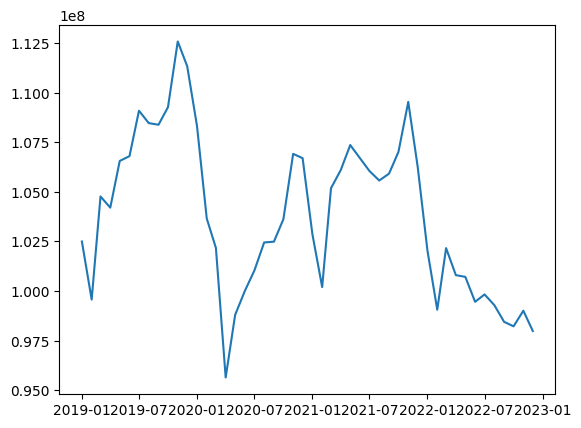

In [17]:
# how retrieve adjustment function is used to retrieve and you can see the plot of cardholders
df_spoc = bq.read_full_bq_table(
    client,
    f"ons-fintrans-analysis-prod.fin_wip_notebook.{retrieve_adjustment_table('spoc','M')}",
)
plt.plot("date_time", "cardholders_all", data=df_spoc.sort_values("date_time"))
# The plot shows we may need to work on these tables and adjust differently i.e. use vicky's tables but
# we could end up having one adjustment table and adjusting like that
# Theoretically could probably join within the sql statement for efficiency purposes rather than via pandas

In [8]:
df_check = bq.read_full_bq_table(
    client, "ons-fintrans-analysis-prod.fin_wip_notebook.sml_cardholders_q"
)

Table has (16, 3) dimensions
Table took 1 seconds to load


In [9]:
df_check

,date_time,time_period_value,cardholders_all
0,2019-03-01,2019Q1,78353586.0
1,2019-09-01,2019Q3,82030294.0
2,2019-06-01,2019Q2,80295837.0
3,2019-12-01,2019Q4,82002148.0
4,2022-09-01,2022Q3,71961887.0
5,2021-03-01,2021Q1,64851574.0
6,2020-03-01,2020Q1,78022914.0
7,2020-09-01,2020Q3,72944200.0
8,2021-09-01,2021Q3,73276176.0
9,2021-12-01,2021Q4,72939814.0


In [18]:
df1 = t.read_spend_merchant_location(client, mcg="")

The SQL statement you have just selected is:         SELECT DATETIME( CAST(SUBSTRING(time_period_value, 1,4) AS int),        CAST(SUBSTRING(time_period_value,6,6)AS int)*3, 01,00,00,00) AS        date_time,  * , FROM        ons-fintrans-data-prod.fintrans_visa.spend_merchant_location        WHERE        time_period LIKE 'Quarter%' AND        cardholder_issuing_level LIKE 'All%' AND        merchant_location_level LIKE 'All%' AND        mcg LIKE '%' AND        mcc LIKE 'All%' ORDER BY time_period, time_period_value
Table has (394, 14) dimensions
Table took 1 seconds to load


In [19]:
df1

,date_time,time_period,time_period_value,merchant_location_level,merchant_location,cardholder_issuing_level,cardholder_issuing_country,mcg,mcc,spend,transactions,cardholders,dist_merchants,pct_repeat_pan_cnt
0,2019-03-01,Quarter,2019Q1,All,All,All,All,PROFESSIONAL SERVICES,All,5.016812e+08,15499287.0,6633474.0,19952.0,0.2746
1,2019-03-01,Quarter,2019Q1,All,All,All,All,AIRLINES,All,3.463953e+07,678738.0,486749.0,116.0,0.2308
2,2019-03-01,Quarter,2019Q1,All,All,All,All,HEALTH CARE,All,4.621310e+08,6347914.0,3786221.0,3763.0,0.3128
3,2019-03-01,Quarter,2019Q1,All,All,All,All,EDUCATION & GOVERNMENT,All,1.107553e+09,42007159.0,14782263.0,11357.0,0.3388
4,2019-03-01,Quarter,2019Q1,All,All,All,All,HOME IMPROVEMENT & SUPPLY,All,5.174372e+09,127635466.0,33769547.0,52277.0,0.4452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,2022-12-01,Quarter,2022Q4,All,All,All,All,DISCOUNT STORES,All,2.411493e+09,119418460.0,30651042.0,3999.0,0.4409
390,2022-12-01,Quarter,2022Q4,All,All,All,All,TRAVEL SERVICES,All,1.709633e+08,393950.0,292637.0,1262.0,0.1752
391,2022-12-01,Quarter,2022Q4,All,All,All,All,FUEL,All,7.507574e+09,246849903.0,33161505.0,4864.0,0.6443
392,2022-12-01,Quarter,2022Q4,All,All,All,All,RESTAURANTS,All,6.108637e+09,390416622.0,42430146.0,76562.0,0.5654


In [20]:
df3 = create_adjusted_value(df1, "sml", "Quarter")
df3
# using the final function! 

Table has (16, 3) dimensions
Table took 1 seconds to load


,date_time,time_period,time_period_value,merchant_location_level,merchant_location,cardholder_issuing_level,cardholder_issuing_country,mcg,mcc,spend,transactions,cardholders,dist_merchants,pct_repeat_pan_cnt,cardholders_all,adj_spend,adj_transactions
0,2019-03-01,Quarter,2019Q1,All,All,All,All,PROFESSIONAL SERVICES,All,5.016812e+08,15499287.0,6633474.0,19952.0,0.2746,78353586.0,6.402785,0.197812
1,2019-03-01,Quarter,2019Q1,All,All,All,All,AIRLINES,All,3.463953e+07,678738.0,486749.0,116.0,0.2308,78353586.0,0.442092,0.008663
2,2019-03-01,Quarter,2019Q1,All,All,All,All,HEALTH CARE,All,4.621310e+08,6347914.0,3786221.0,3763.0,0.3128,78353586.0,5.898020,0.081016
3,2019-03-01,Quarter,2019Q1,All,All,All,All,EDUCATION & GOVERNMENT,All,1.107553e+09,42007159.0,14782263.0,11357.0,0.3388,78353586.0,14.135324,0.536123
4,2019-03-01,Quarter,2019Q1,All,All,All,All,HOME IMPROVEMENT & SUPPLY,All,5.174372e+09,127635466.0,33769547.0,52277.0,0.4452,78353586.0,66.038742,1.628968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,2022-12-01,Quarter,2022Q4,All,All,All,All,DISCOUNT STORES,All,2.411493e+09,119418460.0,30651042.0,3999.0,0.4409,69262328.0,34.816807,1.724147
390,2022-12-01,Quarter,2022Q4,All,All,All,All,TRAVEL SERVICES,All,1.709633e+08,393950.0,292637.0,1262.0,0.1752,69262328.0,2.468345,0.005688
391,2022-12-01,Quarter,2022Q4,All,All,All,All,FUEL,All,7.507574e+09,246849903.0,33161505.0,4864.0,0.6443,69262328.0,108.393322,3.563985
392,2022-12-01,Quarter,2022Q4,All,All,All,All,RESTAURANTS,All,6.108637e+09,390416622.0,42430146.0,76562.0,0.5654,69262328.0,88.195659,5.636782


In [ ]:
df3 = t.create_index(df3, "adj_spend", t.get_cat_vars("sml"))

In [ ]:
df3

In [ ]:
plt.plot(
    "date_time",
    "adj_spend_index",
    data=df3[df3["mcg"] == "TRAVEL SERVICES"].sort_values("date_time"),
)